# model

## Install package

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
! pip install --upgrade albumentations

In [5]:
!pip uninstall opencv-python-headless==4.5.5.62 -y

Found existing installation: opencv-python-headless 4.5.2.52
Uninstalling opencv-python-headless-4.5.2.52:
  Successfully uninstalled opencv-python-headless-4.5.2.52


In [6]:
!pip install opencv-python-headless==4.5.2.52

  Using cached opencv_python_headless-4.5.2.52-cp38-cp38-manylinux2014_x86_64.whl (38.2 MB)


In [7]:
!pip install python-gdcm pydicom

In [8]:
!pip install pandas

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Resize
from torchvision.io import read_image, ImageReadMode
# import torchmetrics
import torch.nn.functional as F
import numpy as np

print(torch.__version__)

1.10.0a0+3fd9dcf


In [10]:
from albumentations import HorizontalFlip, Rotate, RandomBrightnessContrast, Flip, Compose, RandomResizedCrop
from typing import List, Optional, Dict, Generator, NamedTuple, Any, Tuple, Union, Mapping

In [11]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from multiprocessing import Pool

In [12]:
import gc
import math
from tqdm import tqdm
import time

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


## Set parameter

In [14]:
epochs = 50

labels_col = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumothorax', 'Edema']
classes = 5 # number of findings
image_w = 256
image_h = 256
batch_size = 32

## Create PyTorch Dataset

In [15]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """Convert DICOM file to numy array
    
    Args: 
        path (str): Path to the DICOM file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply MONOCHROME fix
        
    Returns:
        Numpy array of the respective DICOM file
    """
    
    # Use the pydicom library to read the DICOM file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # Depending on this value, X-ray may look inverted - fix that
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    # Normalize the image array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [16]:
class XRayDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, target_transform=None):
      self.img_files = df['Image'].tolist()
      self.img_labels = df[labels_col].values
      self.transform = transform
      self.target_transform = target_transform
      self.image_dir = image_dir

    def __len__(self):
      return len(self.img_labels)

    def __getitem__(self, idx):
      img_path = os.path.join(self.image_dir, self.img_files[idx])
      if '.dcm' in self.img_files[idx]:
        image = dicom2array(img_path)
        image = torch.tensor(image)/255
        image = image.unsqueeze(0)
      else:
        image = read_image(img_path, mode=ImageReadMode.GRAY)/255

      label = self.img_labels[idx]
      label = label.astype('float64')
      if self.transform:
          image = image[0].numpy()
          aug = self.transform(image=image)
          image = torch.from_numpy(aug["image"])
          image = image.unsqueeze(0)
      image = image.unsqueeze(0)
      image = F.interpolate(image, size=image_w)
      image = image[0]
      # image = image.expand(3, -1, -1)
      return image, label

In [17]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [18]:
def augment(p=0.5):
    return Compose([
        RandomResizedCrop(image_h,image_w,scale=(0.7, 1.0), p=1.0),
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(0.5,0.5,p=0.5),
        Rotate(90, border_mode=0, p=0.5),
    ], p=p)
augmentation = augment()

In [19]:
# site_name = 'chula' # edit
# sites = ['chula', 'nih', 'padchest', 'mimic', 'vin']
sites = ['chula', 'nih', 'padchest', 'mimic']
col_list = ['Image', 'Atelectasis', 'Cardiomegaly', 'Edema', 'Effusion', 'Pneumothorax']
labels_col = col_list[1:]

data_path = '/workspace/nvflare/fl-nvflare/data/'

# All datasets is from all sites
train = pd.DataFrame(columns=col_list)
val = pd.DataFrame(columns=col_list)
test = pd.DataFrame(columns=col_list)

for site in sites:
    site_path = data_path+"data_"+site+"/"
    image_path = site_path+"image/"
    
    train_s = pd.read_csv(site_path+"train_"+site+".csv")
    train_s['Image'] = train_s['Image'].apply(lambda x: image_path+x)
    train = pd.concat([train,train_s],axis=0)
    
    val_s = pd.read_csv(site_path+"val_"+site+".csv")
    val_s['Image'] = val_s['Image'].apply(lambda x: image_path+x)
    val = pd.concat([val,val_s],axis=0)
    
    test_s = pd.read_csv(site_path+"test_"+site+".csv")
    test_s['Image'] = test_s['Image'].apply(lambda x: image_path+x)
    test = pd.concat([test,test_s],axis=0)

train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
train

,Image,Atelectasis,Cardiomegaly,Edema,Effusion,Pneumothorax
0,/workspace/nvflare/fl-nvflare/data/data_padche...,0.0,1.0,0.0,0.0,0.0
1,/workspace/nvflare/fl-nvflare/data/data_nih/im...,0.0,0.0,0.0,0.0,0.0
2,/workspace/nvflare/fl-nvflare/data/data_nih/im...,0.0,0.0,0.0,0.0,0.0
3,/workspace/nvflare/fl-nvflare/data/data_chula/...,0.0,1.0,1.0,1.0,0.0
4,/workspace/nvflare/fl-nvflare/data/data_mimic/...,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
17578,/workspace/nvflare/fl-nvflare/data/data_nih/im...,0.0,0.0,0.0,0.0,0.0
17579,/workspace/nvflare/fl-nvflare/data/data_nih/im...,0.0,0.0,0.0,0.0,0.0
17580,/workspace/nvflare/fl-nvflare/data/data_mimic/...,0.0,1.0,0.0,0.0,0.0
17581,/workspace/nvflare/fl-nvflare/data/data_mimic/...,0.0,0.0,0.0,0.0,0.0


In [20]:
train_dataset = XRayDataset(train, data_path, transform=augmentation)
valid_dataset = XRayDataset(val, data_path)
test_dataset = XRayDataset(test, data_path)
train_dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 array([0., 1., 0., 0., 0.]))

In [21]:
type(train_dataset[0][1])
train_dataset[0][1].dtype

dtype('float64')

[0. 0. 0. 0. 0.]
torch.Size([1, 256, 256])


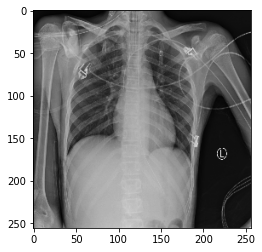

In [22]:
image, label = train_dataset[2]
print(label)
print(image.size())
plt.imshow(image[0], cmap='gray')

In [23]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## PYLON

### import model

In [24]:
!pip install segmentation-models-pytorch

In [25]:
# specify path (must have pylon folder in working directory)
# !cp -R '/workspace/nvflare/fl-nvflare/mmar/custom/pylon' '/workspace/nvflare/fl-nvflare/pylon'

In [26]:
from segmentation_models_pytorch.base import (SegmentationHead,
                                              SegmentationModel)
from segmentation_models_pytorch.encoders import get_encoder
from torch import nn
from pylon.trainer.start import *
from pylon.utils.pretrain import *

from pylon.model.common import *


In [27]:
@dataclass
class PylonConfig:
    n_in: int
    n_out: int
    backbone: str = 'resnet50'
    weights: str = 'imagenet'
    # number of decoding feature maps
    n_dec_ch: int = 128
    # number of UP modules
    n_up: int = 3
    # prediction head kernel size
    seg_kern_size: int = 1
    # whether to use pyramidal attention
    use_pa: bool = True
    # UP module's conv layers
    # '1layer' or '2layer' (default)
    up_type: str = '2layer'
    # UP module's conv kernel size
    up_kernel_size: int = 1
    # freeze?
    # 'enc' to freeze the encoder
    freeze: str = None
    # pretraining configs
    pretrain_conf: PretrainConfig = None

    @property
    def name(self):
        name = f'pylon-{self.backbone}'
        if not self.use_pa:
            name += '-nopa'
        name += f'-uptype{self.up_type}'
        if self.up_kernel_size != 1:
            name += f'-upkern{self.up_kernel_size}'
        if self.n_up != 3:
            name += f'-up{self.n_up}'
        if self.weights is not None:
            name += f'-{self.weights}'
        name += f'-dec{self.n_dec_ch}'
        if self.seg_kern_size != 1:
            name += f'-segkern{self.seg_kern_size}'
        if self.freeze is not None:
            name += f'_freeze{self.freeze}'
        if self.pretrain_conf is not None:
            name += f'_{self.pretrain_conf.name}'
        return name

    def make_model(self):
        return Pylon(self)


class Pylon(nn.Module):
    def __init__(self, conf: PylonConfig):
        super(Pylon, self).__init__()
        self.conf = conf
        self.net = PylonCore(backbone=conf.backbone,
                             n_in=conf.n_in,
                             n_out=conf.n_out,
                             weights=conf.weights,
                             n_dec_ch=conf.n_dec_ch,
                             use_pa=conf.use_pa,
                             up_type=conf.up_type,
                             up_kernel_size=conf.up_kernel_size,
                             n_up=conf.n_up,
                             seg_kern_size=conf.seg_kern_size)
        self.pool = nn.AdaptiveMaxPool2d(1)

        if conf.pretrain_conf is not None:
            load_pretrain(conf.pretrain_conf, self)

        if conf.freeze is not None:
            if conf.freeze == 'enc':
                self.net.encoder.requires_grad_(False)
            else:
                raise NotImplementedError()

    def forward(self, img, classification=None, **kwargs):
        # enforce float32 is a good idea
        # because if the loss function involves a reduction operation
        # it would be harmful, this prevents the problem
        seg = self.net(img).float()
        pred = self.pool(seg)
        pred = torch.flatten(pred, start_dim=1)

        loss = None
        loss_pred = None
        loss_bbox = None
        if classification is not None:
            loss_pred = F.binary_cross_entropy_with_logits(
                pred, classification.float())
            loss = loss_pred

        return ModelReturn(
            pred=pred,
            pred_seg=seg,
            loss=loss,
            loss_pred=loss_pred,
            loss_bbox=loss_bbox,
        )


class PylonCore(SegmentationModel):
    def __init__(self,
                 backbone: str,
                 n_in: int,
                 n_out: int,
                 weights: str = 'imagenet',
                 n_dec_ch: int = 128,
                 use_pa: bool = True,
                 up_type: str = '2layer',
                 up_kernel_size: int = 1,
                 n_up: int = 3,
                 seg_kern_size: int = 1):
        super(PylonCore, self).__init__()

        self.encoder = get_encoder(
            backbone,
            in_channels=n_in,
            depth=5,
            weights=weights,
        )

        self.decoder = PylonDecoder(
            encoder_channels=self.encoder.out_channels,
            n_dec_ch=n_dec_ch,
            use_pa=use_pa,
            up_type=up_type,
            up_kernel_size=up_kernel_size,
            n_up=n_up,
        )

        self.segmentation_head = SegmentationHead(in_channels=n_dec_ch,
                                                  out_channels=n_out,
                                                  activation=None,
                                                  kernel_size=seg_kern_size,
                                                  upsampling=1)

        # just to comply with SegmentationModel
        self.classification_head = None
        self.initialize()


class PylonDecoder(nn.Module):
    """returns each layer of decoder
    """
    def __init__(
        self,
        encoder_channels,
        n_dec_ch: int,
        use_pa: bool = True,
        up_type: str = '2layer',
        up_kernel_size: int = 1,
        n_up: int = 3,
        upscale_mode: str = 'bilinear',
        align_corners=True,
    ):
        super(PylonDecoder, self).__init__()
        self.n_up = n_up

        self.pa = PA(
            in_channels=encoder_channels[-1],
            out_channels=n_dec_ch,
            align_corners=align_corners,
            use_pa=use_pa,
        )

        kwargs = dict(
            out_channels=n_dec_ch,
            upscale_mode=upscale_mode,
            align_corners=align_corners,
            up_type=up_type,
            kernel_size=up_kernel_size,
        )
        if n_up >= 1:
            self.up3 = UP(
                in_channels=encoder_channels[-2],
                **kwargs,
            )
        if n_up >= 2:
            self.up2 = UP(
                in_channels=encoder_channels[-3],
                **kwargs,
            )
        if n_up >= 3:
            self.up1 = UP(
                in_channels=encoder_channels[-4],
                **kwargs,
            )

    def forward(self, *features):
        bottleneck = features[-1]
        x = self.pa(bottleneck)  # 1/32
        if self.n_up >= 1:
            x = self.up3(features[-2], x)  # 1/16
        if self.n_up >= 2:
            x = self.up2(features[-3], x)  # 1/8
        if self.n_up >= 3:
            x = self.up1(features[-4], x)  # 1/4
        return x


class PA(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        use_pa: bool = True,
        upscale_mode='bilinear',
        align_corners=True,
    ):
        super(PA, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None
        self.use_pa = use_pa

        # middle branch
        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ))

        # pyramid attention branch
        if use_pa:
            self.down1 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=in_channels,
                           out_channels=1,
                           kernel_size=7,
                           stride=1,
                           padding=3))
            self.down2 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=5,
                           stride=1,
                           padding=2))
            self.down3 = nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                ConvBnRelu(in_channels=1,
                           out_channels=1,
                           kernel_size=3,
                           stride=1,
                           padding=1))

            self.conv3 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1)
            self.conv2 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=5,
                                    stride=1,
                                    padding=2)
            self.conv1 = ConvBnRelu(in_channels=1,
                                    out_channels=1,
                                    kernel_size=7,
                                    stride=1,
                                    padding=3)

    def forward(self, x):
        upscale_parameters = dict(mode=self.upscale_mode,
                                  align_corners=self.align_corners)

        mid = self.mid(x)

        if self.use_pa:
            x1 = self.down1(x)
            x2 = self.down2(x1)
            x3 = self.down3(x2)
            x = F.interpolate(self.conv3(x3),
                              scale_factor=2,
                              **upscale_parameters)
            x = F.interpolate(self.conv2(x2) + x,
                              scale_factor=2,
                              **upscale_parameters)
            x = F.interpolate(self.conv1(x1) + x,
                              scale_factor=2,
                              **upscale_parameters)
            x = torch.mul(x, mid)
        else:
            x = mid
        return x


class UP(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        up_type: str = '2layer',
        kernel_size: int = 1,
        upscale_mode: str = 'bilinear',
        align_corners=True,
    ):
        super(UP, self).__init__()

        self.upscale_mode = upscale_mode
        self.align_corners = align_corners if upscale_mode == 'bilinear' else None

        if up_type == '1layer':
            self.conv1 = ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
            )
        elif up_type == '2layer':
            self.conv1 = nn.Sequential(
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
                ConvBnRelu(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                ),
            )
        else:
            raise NotImplementedError()

    def forward(self, x, y):
        """
        Args:
            x: low level feature
            y: high level feature
        """
        h, w = x.size(2), x.size(3)
        y_up = F.interpolate(y,
                             size=(h, w),
                             mode=self.upscale_mode,
                             align_corners=self.align_corners)
        conv = self.conv1(x)
        return y_up + conv


class ConvBnRelu(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 add_bn: bool = True,
                 add_relu: bool = True,
                 bias: bool = True,
                 interpolate: bool = False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding,
                              dilation=dilation,
                              bias=bias,
                              groups=groups)
        self.add_relu = add_relu
        self.add_bn = add_bn
        self.interpolate = interpolate
        if add_bn:
            self.bn = nn.BatchNorm2d(out_channels)
        if add_relu:
            self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.add_bn:
            x = self.bn(x)
        if self.add_relu:
            x = self.activation(x)
        if self.interpolate:
            x = F.interpolate(x,
                              scale_factor=2,
                              mode='bilinear',
                              align_corners=True)
        return x

### create model

In [28]:
net_conf=PylonConfig(
            n_in=1,
            n_out=classes,
            up_type='2layer',
#             pretrain_conf=PretrainConfig(
#                 pretrain_name='nih',
#                 path='/workspace/nvflare/fl-nvflare/pylon,nih,256.pkl',
#             ),
#             freeze='enc',
        )
# uncomment when training

In [28]:
model=net_conf.make_model()

err: _IncompatibleKeys(missing_keys=['net.segmentation_head.0.weight', 'net.segmentation_head.0.bias'], unexpected_keys=[])


In [29]:
model.to(device)

Pylon(
  (net): PylonCore(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  

In [31]:
loss_arr = []
val_loss_arr = []
min_loss = 10

early_stopping = EarlyStopping(patience=10)
end_epoch = 0

for epoch in range(epochs):
  print(f'Epoch {epoch}/{epochs-1}')

  # train
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(train_dataloader)
  model.train()
  for i, (images, labels) in enumerate(train_dataloader):  
    images = images.to(device)
    labels = labels.to(device)
    # forward
    # track history if only in train
    with torch.set_grad_enabled(True):
      outputs = model(images)
      outputs = outputs.pred
      # print(outputs)
      loss = criterion(outputs, labels.float())
  
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * images.size(0)
      if (i+1) % 50 == 0:
          print (f'[Train] Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, time: {(time.time()-s):.4f}s')
          s = time.time()
  epoch_loss = running_loss / len(train_dataset)
  loss_arr.append(epoch_loss)
  print (f'[Train] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')

  # eval
  running_loss = 0.0
  s = time.time()
  n_total_steps = len(valid_dataloader)
  model.eval()
  for i, (images, labels) in enumerate(valid_dataloader):  
    images = images.to(device)
    labels = labels.to(device)

    # forward
    with torch.set_grad_enabled(False):
      outputs = model(images)
      outputs = outputs.pred
      loss = criterion(outputs, labels.float())
      running_loss += loss.item() * images.size(0)
  
  epoch_loss = running_loss / len(valid_dataset)
  val_loss_arr.append(epoch_loss)
  # save model with min loss
  if min_loss > epoch_loss:
    min_loss = epoch_loss
    torch.save(model.state_dict(), 'model_best.pth')
    print(f'Save model_best, Loss: {epoch_loss:.4f}')

  early_stopping(epoch_loss)
  if early_stopping.early_stop:
    print(f"Early stopping at val_loss : {epoch_loss}")
    end_epoch = epoch
    break

  print (f'[Eval] Epoch {epoch}/{epochs-1}, Loss: {epoch_loss:.4f}')
  print('-' * 10)
  end_epoch = epoch

Epoch 0/49
[Train] Step [50/550], Loss: 0.9913, time: 45.6322s
[Train] Step [100/550], Loss: 0.5539, time: 43.7114s
[Train] Step [150/550], Loss: 0.4424, time: 46.0064s
[Train] Step [200/550], Loss: 0.3929, time: 43.9917s
[Train] Step [250/550], Loss: 0.2614, time: 45.3710s
[Train] Step [300/550], Loss: 0.3655, time: 44.7541s
[Train] Step [350/550], Loss: 0.2749, time: 51.6874s
[Train] Step [400/550], Loss: 0.2653, time: 72.6959s
[Train] Step [450/550], Loss: 0.3309, time: 56.1748s
[Train] Step [500/550], Loss: 0.3103, time: 50.3921s
[Train] Step [550/550], Loss: 0.2608, time: 47.4145s
[Train] Epoch 0/49, Loss: 0.4979
Save model_best, Loss: 0.2606
[Eval] Epoch 0/49, Loss: 0.2606
----------
Epoch 1/49
[Train] Step [50/550], Loss: 0.3098, time: 44.9059s
[Train] Step [100/550], Loss: 0.2921, time: 44.8495s
[Train] Step [150/550], Loss: 0.3080, time: 42.9851s
[Train] Step [200/550], Loss: 0.3008, time: 70.3284s
[Train] Step [250/550], Loss: 0.2138, time: 62.7505s
[Train] Step [300/550], Lo

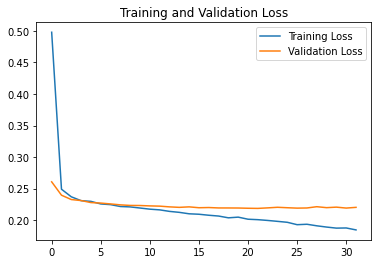

In [44]:
plt.plot(range(end_epoch+1), loss_arr, label='Training Loss')
plt.plot(range(end_epoch+1), val_loss_arr, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
plt.savefig('all_sites_loss.png')

<Figure size 432x288 with 0 Axes>

### predict

In [29]:
model2 = net_conf.make_model()
model2.load_state_dict(torch.load('model_best.pth')) 
# model.state_dict()
model2.to(device)

Pylon(
  (net): PylonCore(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [30]:
model2.eval()
y_pred = []
y = []

with torch.no_grad():
    for i, (images, labels) in enumerate(test_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        outputs = outputs.pred
        y_pred.extend(torch.sigmoid(outputs))
        y.extend(labels)
y_pred = torch.stack(y_pred).cpu()
y = torch.stack(y).cpu()

In [31]:
target_names = labels_col
from sklearn.metrics import classification_report, multilabel_confusion_matrix
report = classification_report(y==1, y_pred>=0.5, digits=4, target_names=target_names)
print(report)

              precision    recall  f1-score   support

 Atelectasis     0.6022    0.3125    0.4115       528
Cardiomegaly     0.7273    0.6185    0.6685       802
       Edema     0.5310    0.3195    0.3990       241
    Effusion     0.6881    0.7064    0.6971       637
Pneumothorax     0.7895    0.2326    0.3593       129

   micro avg     0.6793    0.5212    0.5898      2337
   macro avg     0.6676    0.4379    0.5071      2337
weighted avg     0.6715    0.5212    0.5734      2337
 samples avg     0.2446    0.2255    0.2253      2337



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
!pip install seaborn

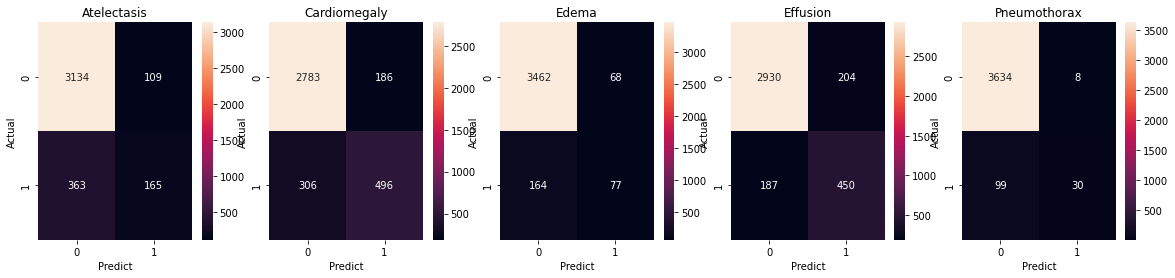

In [33]:
import seaborn as sns
fig, ax = plt.subplots(1,5,figsize=(20,4))
for i in range(classes):
    sns.heatmap(multilabel_confusion_matrix(y==1,y_pred>=0.5)[i], annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(target_names[i])
    ax[i].set_xlabel("Predict")
    ax[i].set_ylabel("Actual")

In [39]:
# fig.savefig('all_sites.png', format='png', bbox_inches='tight')

In [35]:
import sklearn.metrics

print("AUPRC")
auprc = sklearn.metrics.average_precision_score(y, y_pred)
print('all classes',auprc)
auprc = sklearn.metrics.average_precision_score(y[:, 0], y_pred[:, 0])
print('Atelectasis:',auprc)
auprc = sklearn.metrics.average_precision_score(y[:, 1], y_pred[:, 1])
print('Cardiomegaly:',auprc)
auprc = sklearn.metrics.average_precision_score(y[:, 2], y_pred[:, 2])
print('Effusion:',auprc)
auprc = sklearn.metrics.average_precision_score(y[:, 3], y_pred[:, 3])
print('Pneumothorax:',auprc)
auprc = sklearn.metrics.average_precision_score(y[:, 4], y_pred[:, 4])
print('Edema:',auprc)

AUPRC
all classes 0.571244429039832
Atelectasis: 0.5049749615555148
Cardiomegaly: 0.772716245932676
Effusion: 0.42625734275208793
Pneumothorax: 0.7533738435410892
Edema: 0.3988997514177918
